In [14]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
except ImportError:
    sns = None
    print("Seaborn not installed – using plain Matplotlib plots.")

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
# Notebook launched from: Deep_Learning_project/notebooks
PROJECT_ROOT = os.path.abspath("..")
RUN_NAME = "main_cnn_150epochs"

BASE_DIR = os.path.join(PROJECT_ROOT, "experiments", "evaluation", RUN_NAME)
CONF_DIR = os.path.join(BASE_DIR, "confusion")
GRADCAM_DIR = os.path.join(BASE_DIR, "gradcam")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("BASE_DIR    :", BASE_DIR)
print("CONF_DIR    :", CONF_DIR)
print("GRADCAM_DIR :", GRADCAM_DIR)


PROJECT_ROOT: c:\Users\mathy\OneDrive - Groupe INSEEC (POCE)\Bureau\Centrale\Deep Learning\Deep_Learning_project
BASE_DIR    : c:\Users\mathy\OneDrive - Groupe INSEEC (POCE)\Bureau\Centrale\Deep Learning\Deep_Learning_project\experiments\evaluation\main_cnn_150epochs
CONF_DIR    : c:\Users\mathy\OneDrive - Groupe INSEEC (POCE)\Bureau\Centrale\Deep Learning\Deep_Learning_project\experiments\evaluation\main_cnn_150epochs\confusion
GRADCAM_DIR : c:\Users\mathy\OneDrive - Groupe INSEEC (POCE)\Bureau\Centrale\Deep Learning\Deep_Learning_project\experiments\evaluation\main_cnn_150epochs\gradcam


In [2]:
# Paths for this run
overall_path = os.path.join(BASE_DIR, "test_overall_metrics.csv")
per_class_path = os.path.join(BASE_DIR, "test_per_class_metrics.csv")
preds_path = os.path.join(BASE_DIR, "test_predictions.csv")


print("File existence:")
for p in [overall_path, per_class_path, preds_path]:
    print(os.path.basename(p), "->", os.path.exists(p))

# Load dataframes (None if missing)
overall_df = pd.read_csv(overall_path) if os.path.exists(overall_path) else None
per_class_df = pd.read_csv(per_class_path) if os.path.exists(per_class_path) else None
preds_df = pd.read_csv(preds_path) if os.path.exists(preds_path) else None


overall_df, per_class_df


File existence:
test_overall_metrics.csv -> True
test_per_class_metrics.csv -> True
test_predictions.csv -> True


(  split  accuracy  balanced_accuracy  macro_f1  weighted_f1
 0  test  0.551077           0.546537  0.491144     0.533712,
     emotion  precision    recall        f1  support
 0   neutral   0.511699  0.540860  0.525876      930
 1     happy   0.732895  0.825797  0.776577     1349
 2       sad   0.447174  0.399123  0.421784      912
 3  surprise   0.646259  0.791667  0.711610      600
 4      fear   0.438406  0.157552  0.231801      768
 5   disgust   0.229787  0.658537  0.340694       82
 6     anger   0.409257  0.452221  0.429668      743)

In [3]:
if overall_df is None:
    print("Overall metrics CSV not found.")
else:
    display(overall_df)

    acc = overall_df["accuracy"].iloc[0]
    bal_acc = overall_df["balanced_accuracy"].iloc[0]
    macro_f1 = overall_df["macro_f1"].iloc[0]
    w_f1 = overall_df["weighted_f1"].iloc[0]

    print(f"\nGlobal test metrics for run '{RUN_NAME}':")
    print(f"- Accuracy          : {acc:.4f}")
    print(f"- Balanced accuracy : {bal_acc:.4f}")
    print(f"- Macro F1          : {macro_f1:.4f}")
    print(f"- Weighted F1       : {w_f1:.4f}")


,split,accuracy,balanced_accuracy,macro_f1,weighted_f1
0,test,0.551077,0.546537,0.491144,0.533712



Global test metrics for run 'main_cnn_150epochs':
- Accuracy          : 0.5511
- Balanced accuracy : 0.5465
- Macro F1          : 0.4911
- Weighted F1       : 0.5337


In [4]:
per_class_df = per_class_df[["emotion","precision","recall","f1"]]

# retirer la ligne où = 0
per_class_df = per_class_df[(per_class_df["precision"] != 0) & (per_class_df["recall"] != 0) & (per_class_df["f1"] != 0)]
if per_class_df is None:
    print("Per-class metrics CSV not found.")
else:
    print("Per-class metrics:")
    display(per_class_df)


Per-class metrics:


,emotion,precision,recall,f1
0,neutral,0.511699,0.540860,0.525876
1,happy,0.732895,0.825797,0.776577
2,sad,0.447174,0.399123,0.421784
3,surprise,0.646259,0.791667,0.711610
4,fear,0.438406,0.157552,0.231801
5,disgust,0.229787,0.658537,0.340694
6,anger,0.409257,0.452221,0.429668


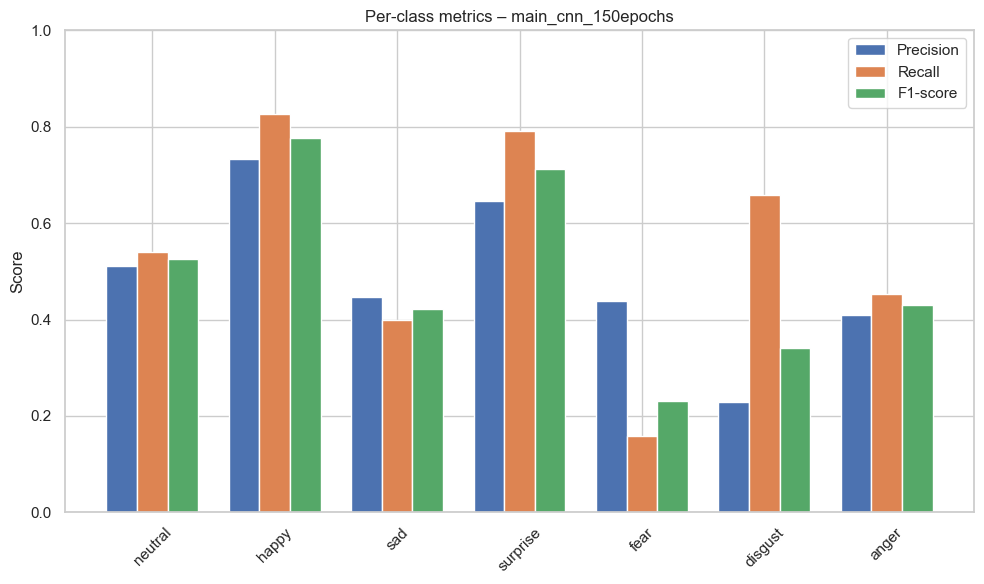

In [5]:
if per_class_df is None:
    print("Per-class metrics CSV not found.")
else:
    emotions = per_class_df["emotion"].values
    x = np.arange(len(emotions))

    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, per_class_df["precision"], width, label="Precision")
    plt.bar(x, per_class_df["recall"], width, label="Recall")
    plt.bar(x + width, per_class_df["f1"], width, label="F1-score")

    plt.xticks(x, emotions, rotation=45)
    plt.ylabel("Score")
    plt.ylim(0, 1.0)
    plt.title(f"Per-class metrics – {RUN_NAME}")
    plt.legend()
    plt.tight_layout()
    plt.show()


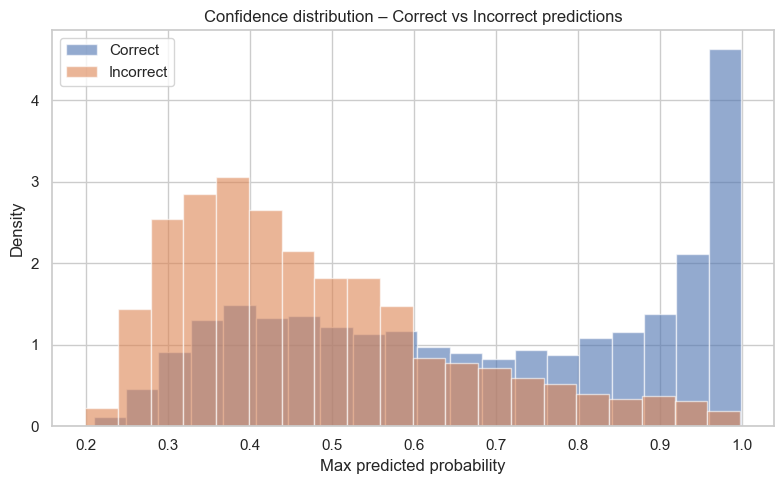

In [6]:
if preds_df is None:
    print("Predictions CSV not found.")
else:
    # Identify probability columns
    prob_cols = [c for c in preds_df.columns if c.startswith("prob_")]
    if not prob_cols:
        print("No probability columns found in predictions CSV.")
    else:
        # For each row, take the max prob as model confidence
        prob_matrix = preds_df[prob_cols].values
        max_conf = prob_matrix.max(axis=1)
        preds_df["max_confidence"] = max_conf

        correct_conf = preds_df.loc[preds_df["correct"], "max_confidence"]
        wrong_conf = preds_df.loc[~preds_df["correct"], "max_confidence"]

        plt.figure(figsize=(8, 5))
        plt.hist(correct_conf, bins=20, alpha=0.6, label="Correct", density=True)
        plt.hist(wrong_conf, bins=20, alpha=0.6, label="Incorrect", density=True)
        plt.xlabel("Max predicted probability")
        plt.ylabel("Density")
        plt.title("Confidence distribution – Correct vs Incorrect predictions")
        plt.legend()
        plt.tight_layout()
        plt.show()


Grad-CAM correct directory: c:\Users\mathy\OneDrive - Groupe INSEEC (POCE)\Bureau\Centrale\Deep Learning\Deep_Learning_project\experiments\evaluation\main_cnn_150epochs\gradcam\correct


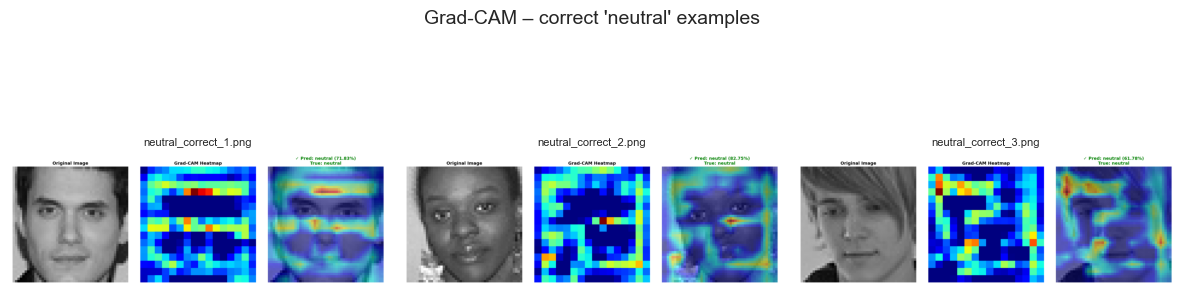

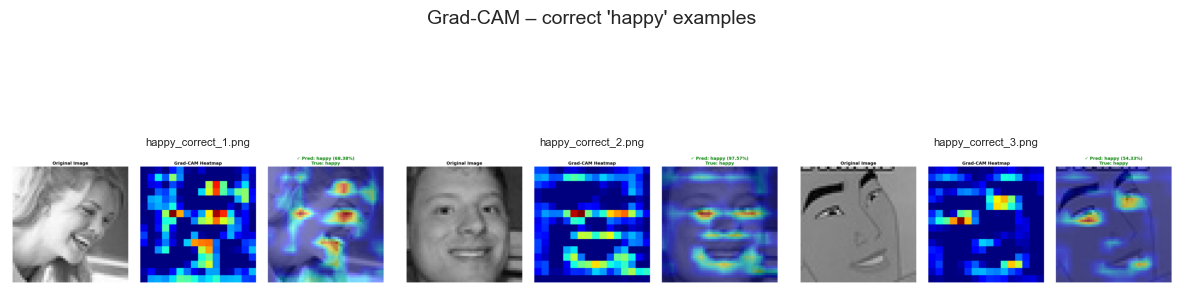

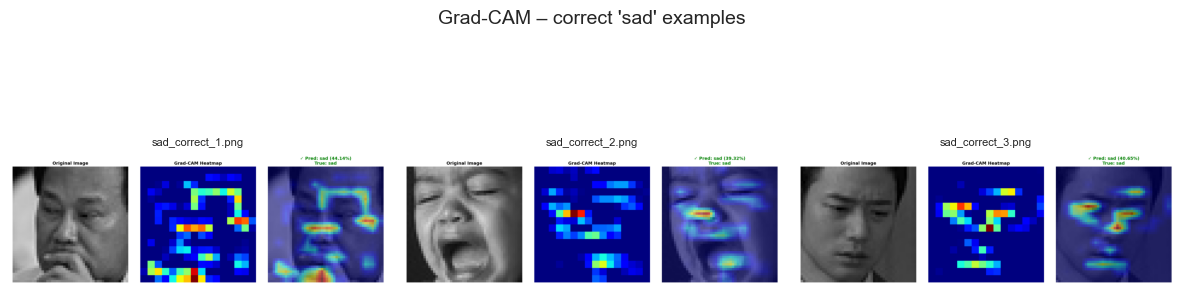

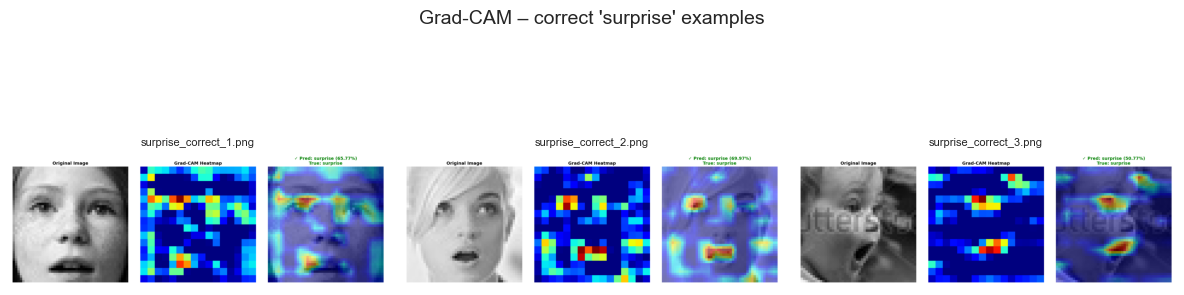

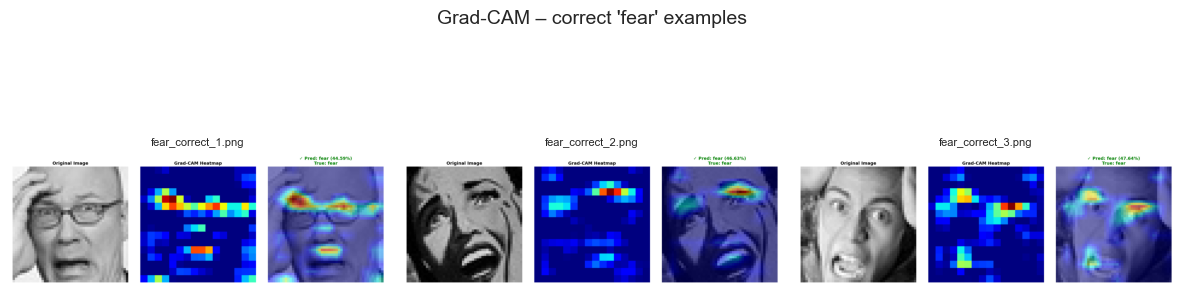

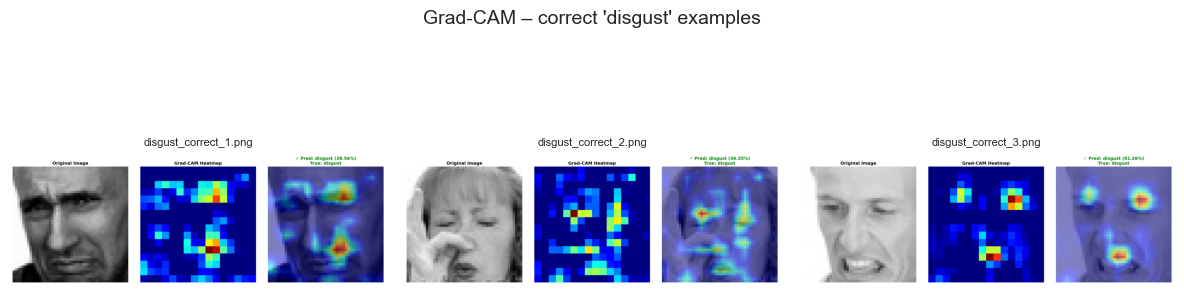

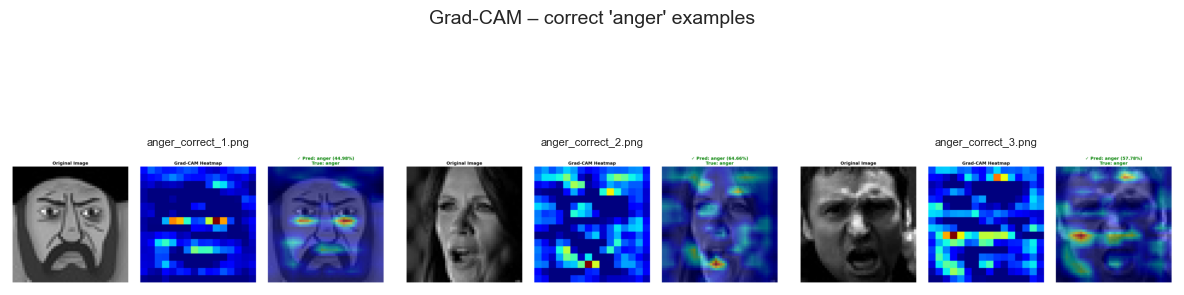

In [7]:
import glob
from PIL import Image

def show_image_grid(image_paths, title, n_cols=3, max_images=9):
    image_paths = image_paths[:max_images]
    n_images = len(image_paths)
    if n_images == 0:
        print(f"No images found for {title}")
        return

    n_cols = min(n_cols, n_images)
    n_rows = int(np.ceil(n_images / n_cols))

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show correct Grad-CAM visualizations for each emotion
correct_dir = os.path.join(GRADCAM_DIR, "correct")

if not os.path.isdir(correct_dir):
    print("No Grad-CAM 'correct' directory found:", correct_dir)
else:
    print("Grad-CAM correct directory:", correct_dir)
    # Example: visualize some images per emotion
    emotions_to_show = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger"]
    for emo in emotions_to_show:
        pattern = os.path.join(correct_dir, f"{emo}_correct_*.png")
        paths = sorted(glob.glob(pattern))
        if paths:
            show_image_grid(paths, title=f"Grad-CAM – correct '{emo}' examples")
        else:
            print(f"No correct Grad-CAM images found for emotion: {emo}")
